In [1]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
from scipy.optimize import linprog

from matplotlib import pyplot as plt
from citk.layer import Dense, FuzzyGMDHLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE
from citk.optimisers import SGDOptimizer, SimplexOptimizer

from utils import get_and_process_boston_dataset, visualise_boston, seed_everything

%matplotlib inline

# Data

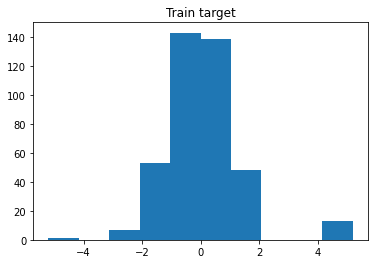

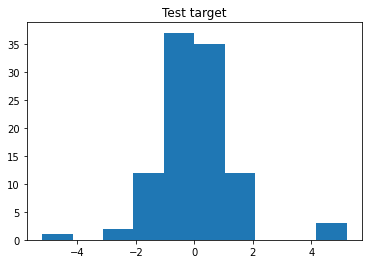

In [2]:
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

X_train, X_test, y_train, y_test = get_and_process_boston_dataset(random_state=RANDOM_SEED)

visualise_boston(X_train, X_test, y_train, y_test)

# GMDH Hypersearh

## Possible architectures

If we have one GMDH layer - GMDH -> Dense

If we have two or more GMDH layers - ( GMDH -> Dense (F - outputs) ) * (N_GMDH_layers-1) -> GMDH -> Dense

In [3]:
model = GMDH(
        input_shape=2, 
        method_type='crisp', 
        poli_type='partial_quadratic',
        loss=MSE, 
        confidence=0.9,
        reg_coef=0.01
    )

In [50]:
def gmdh_pipeline_predict(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs: tp.Dict[tp.Tuple[int], np.ndarray],
                  model_weights: tp.Dict[tp.Tuple[int], np.ndarray]) -> np.ndarray:
    outputs = []
    for k, model in models.items():
        predicted = model_weights[i] * model.predict(inputs[k]).ravel()
        outputs.append(predicted)
    outputs = np.array(outputs).T
    return np.sum(outputs, axis=1)[..., np.newaxis]

def gmdh_pipeline_fit(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs_train: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_train: np.ndarray,
                  inputs_val: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_val: np.ndarray) -> np.ndarray:
    outputs_partial_train = []
    outputs_partial_test = []
    for k, model in models.items():
        predicted_train = model.predict(inputs_train[k]).ravel()
        outputs_partial_train.append(predicted_train)
        predicted_test = model.predict(inputs_val[k]).ravel()
        outputs_partial_test.append(predicted_test)
    outputs_partial_train = np.array(outputs_partial_train).T
    outputs_partial_test = np.array(outputs_partial_test).T

    model = FFN(input_shape=outputs_partial_train.shape[1], 
            layer_specs=[
                Dense(1, nonlinearity=Linear)
            ], 
            loss=MSE, 
            reg_coef=0.01)
    trained, history = model.fit(train_sample=(outputs_partial_train, outputs_train),
                validation_sample=(outputs_partial_test, outputs_val),
                optimiser=SGDOptimizer(alpha = 0.1),
                batch_size=32,
                epochs=5_000,
                verbose=False)
    return trained.W_vect, history['train_loss'][-1], history['validation_loss'][-1]

In [ ]:
do_hypersearh = True
n_gmdh_layers = 1
best_activations = 16
all_metrics = []
best_model = None
best_history = None

all_possible_pairs = list(combinations(range(X_train.shape[0]),2))
possible_models = dict()
possible_pairs_train = dict()
possible_pairs_test = dict()
best_W = None

i = 0
while do_hypersearh:
    partial_model = GMDH(
                        input_shape=2, 
                        method_type='fuzzy', 
                        poli_type='partial_quadratic',
                        loss=MSE, 
                        confidence=0.8,
                        reg_coef=0.01
                    )
    print(f"Partial model structure: {partial_model.__dict__}")
    
    trained, history = partial_model.fit(
        train_sample=(X_train[:, all_possible_pairs[i]], y_train),
        validation_sample=(X_test[:, all_possible_pairs[i]], y_test),
        optimiser=SimplexOptimizer(alpha=0.01),
        batch_size=32,
        epochs=500,
        verbose=False
    )
    possible_models.update({all_possible_pairs[i]: trained})
    possible_pairs_train.update({all_possible_pairs[i]: X_train[:, all_possible_pairs[i]]})
    possible_pairs_test.update({all_possible_pairs[i]: X_test[:, all_possible_pairs[i]]})
    
    if (n_gmdh_layers == 1):
        prediction = trained.predict(X_test[:, all_possible_pairs[i]])
        test_metric = MSE(y_test, prediction)[0]
        all_metrics.append(test_metric)
        W_vect = np.array([1.])
    else:
        W_vect, _, _ = gmdh_pipeline_fit(possible_models, possible_pairs_train, y_train, possible_pairs_test, y_test)
        prediction = gmdh_pipeline_predict(possible_models, possible_pairs_test, W_vect)
        test_metric = MSE(y_test, prediction)[0]
        all_metrics.append(test_metric)
    
    print(f"{n_gmdh_layers} scored {test_metric}")
    
    if len(all_metrics) == 1 or all_metrics[-1] < all_metrics[-2]:
        do_hypersearh = True
    else:
        do_hypersearh = False
        best_W = W_vect
        
    n_gmdh_layers += 1
    i += 1

Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x000001C7458A77C0>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.8, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x000001C7458A74F0>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function MSE at 0x000001C7412C1820>, 'W_vect': array([0.06349852, 0.00913508, 0.07635619, 0.15898462, 0.02792552,
       0.0998776 , 0.03773069, 0.00218569])}



1 scored 2.040077611457269
Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x000001C744F0F2E0>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.8, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x000001C744F0F5E0>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function MSE at 0x000001C7412C1820>, 'W_vect': array([0.06349852, 0.00913508, 0.07635619, 0.15898462, 0.02792552,
       0.0998776 , 0.03773069, 0.00218569])}


# Predict and Visualise losses

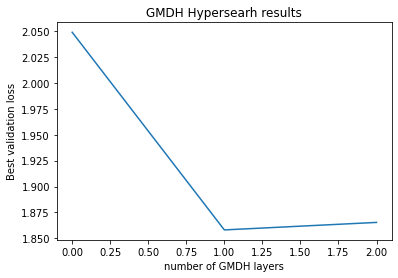

In [46]:
plt.title('GMDH Hypersearh results')
plt.plot(all_metrics)
plt.xlabel('number of GMDH layers')
plt.ylabel('Best validation loss')
plt.show()

In [47]:
prediction = gmdh_pipeline_predict(possible_models, possible_pairs_test, best_W)
prediction_train = gmdh_pipeline_predict(possible_models, possible_pairs_train, best_W)

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 1.9355432672170902
Train MSE: 1.7815974609363827


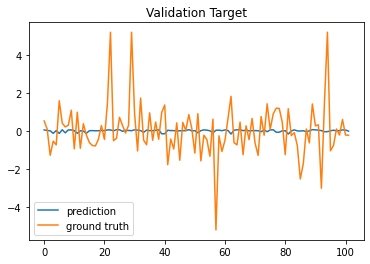

In [48]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

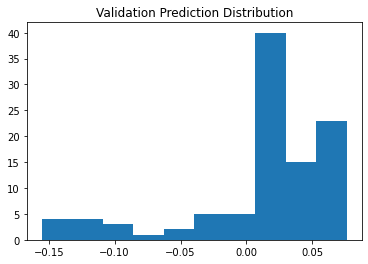

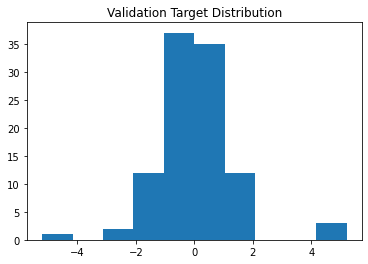

In [49]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()